# Project 4 : West-Nile-Virus-Prediction

### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Further Data Cleaning](#Further-Data-Cleaning)
- [EDA](#EDA)
- [Feature Engineering](#Feature-Engineering)
- [Data Preparation](#Data-Preparation)
- [Modelling](#Modelling)
- [Submission](#Submission)

## Background


https://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health/





The common house mosquito, Culex pipiens (Diptera: Culicidae), which is considered the primary bridge vector of West Nile Virus (WNV) to humans, is a wide spread insect pest with medical importance and consists of two distinct bioforms, Cx. pipiens f. pipiens and Cx. pipiens f. molestus. Here, we consider the adult lifespan of male and female Cx. pipiens f. pipiens under controlled conditions at five constant temperature regimes (15, 20, 25, 27.5, and 30 °C). Our results show that adult longevity was affected by temperature, as it significantly decreased with increase in temperature. At the highest tested temperature, mean adult longevity did not exceed 12 days for both sexes and thus makes impossible the risk of WNV transmission. On the other hand at the lowest temperature, longevity was extremely high with some individuals surviving up to 129 and 132 days, males and females, respectively, and thus enable them to function as potential vectors of WNV for a prolonged period of time. As far as sex is concerned, adult females displayed a 1.2–1.4-fold longer longevity compared to the male ones. However, this difference was significant only at the lowest and highest tested temperature regime. This information is useful in determining the critical temperatures which may affect the distribution of Cx. pipiens and consequently the risk of WNV transmission. Moreover, the effect of environmental temperature should be considered when evaluating the abundance of these species.
https://link.springer.com/article/10.1007/s00436-014-4152-x



https://parasitesandvectors.biomedcentral.com/articles/10.1186/1756-3305-6-129

Background Culex pipiens/restuans mosquitoes are important vectors for a variety of arthropod borne viral infections. In this study, the associations between 20 years of mosquito capture data and the time lagged environmental quantities daytime length, temperature, precipitation, relative humidity and wind speed were used to generate a predictive model for the population dynamics of this vector species. Methods Mosquito population in the study area was represented by averaged time series of mosquitos counts captured at 6 sites in Cook County (Illinois, USA). Cross-correlation maps (CCMs) were compiled to investigate the association between mosquito abundances and environmental quantities. The results obtained from the CCMs were incorporated into a Poisson regression to generate a predictive model. To optimize the predictive model the time lags obtained from the CCMs were adjusted using a genetic algorithm. Results CCMs for weekly data showed a highly positive correlation of mosquito abundances with daytime length 4 to 5 weeks prior to capture (quantified by a Spearman rank order correlation of r S  = 0. 898) and with temperature during 2 weeks prior to capture (r S  = 0. 870). Maximal negative correlations were found for wind speed averaged over 3 week prior to capture (r S  = − 0. 621). Cx. pipiens/restuans population dynamics was predicted by integrating the CCM results in Poisson regression models. They were used to simulate the average seasonal cycle of the mosquito abundance. Verification with observations resulted in a correlation of r S  = 0. 899 for daily and r S  = 0. 917 for weekly data. Applying the optimized models to the entire 20-years time series also resulted in a suitable fit with r S  = 0. 876 for daily and r S  = 0. 899 for weekly data. Conclusions The study demonstrates the application of interval lagged weather data to predict mosquito abundances with a feasible accuracy, especially when related to weekly Cx. pipiens/restuans populations.


# Import Libraries

In [1]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay,accuracy_score, RocCurveDisplay, roc_auc_score

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd



In [2]:
#steps to install geopandas


#!pip install pipwin
#!pipwin install gdal
#!pipwin install fiona
#!pip install geopandas
#!pipwin install rasterio
#pip install contextily

In [3]:
#install category_encoders if needed
#!pip install --upgrade category_encoders

In [4]:
#!pip install lightgbm
#!pip install imblearn

# define some functions

In [5]:
#the
def plot_geodata(dict_df):
    colors = ['black','red','orange','yellow']
    markersizes = [3, 14, 1, 5]
    zorders = [4,3,1,2]
    
    fig_, ax_ = plt.subplots(figsize=(20,20))
    
    #plot neighborhoods map of chicago
    geojson_file = '../assets/Boundaries_Community_Areas.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    #plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    # Create the pandas DataFrame
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude','Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry=gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='purple', markersize=20,zorder=5, label="weather stations")
    
    i=0
    for label_df,df in dict_df.items():
        color_ = colors[i]
        markersize_ = markersizes[i]
        zorder_ = zorders[i]
        label_ = label_df

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_,zorder=zorder_, label=label_)
        i += 1
        
    ax_.legend(loc='lower left', fontsize=12, markerscale=5)
    plt.show()
    return 

In [6]:
def get_weather_data(station =1, # station ID
                     flag = 1,  #1: shift, 2:rolling avg,  3: rolling max
                     feature =None, 
                     k=0 #day lag
                    ):
    if k == 0:
        if station == 1 :
            return df_weather_1[feature]
        else:
            return df_weather_2[feature]
    else:
        if flag == 1: # to shift
             if station == 1 :
                return df_weather_1[feature].shift(k).rename(columns={feature[0]:f'{feature[0]}-{k}'})
             else:
                return df_weather_2[feature].shift(k).rename(columns={feature[0]:f'{feature[0]}-{k}'})
        elif flag == 2: #to avg
             if station == 1 :
                return df_weather_1[feature].rolling(k).mean().rename(columns={feature[0]:f'{feature[0]}-avg-{k}'})
             else:
                return df_weather_2[feature].rolling(k).mean().rename(columns={feature[0]:f'{feature[0]}-avg-{k}'})
        elif flag == 3: #to max
             if station == 1 :
                return df_weather_1[feature].rolling(k).max().rename(columns={feature[0]:f'{feature[0]}-max-{k}'})
             else:
                return df_weather_2[feature].rolling(k).max().rename(columns={feature[0]:f'{feature[0]}-max-{k}'})

In [7]:
def add_weather_features(df, 
                         weather_features_shift=None,
                         weather_features_avg=None,
                         weather_features_max=None
                        ):
    df['id_'] = df.index
    df1 = df.query("Station==1")
    df2 = df.query("Station==2")
    
    features_numeric_weather = ["Tmax","Tmin","Tavg",'DewPoint',"Sunrise",
                                 "Sunset",'Day_length','PrecipTotal','ResultSpeed']                       
                             
    df1 = pd.merge(df1, df_weather_1[features_numeric_weather],on='Date',how='inner')
    df2 = pd.merge(df2, df_weather_2[features_numeric_weather],on='Date',how='inner')
    
    #pd.merge(product,customer,on='Product_ID',how='left')
    for key, value in weather_features_shift.items():
        result_feature_column_1 = get_weather_data(1,1,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,1,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  
    for key, value in weather_features_avg.items():
        result_feature_column_1 = get_weather_data(1,2,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,2,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  

    for key, value in weather_features_max.items():
        result_feature_column_1 = get_weather_data(1,3,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,3,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  


    df_final = pd.concat([df1, df2], sort=False)
    df_final.set_index('id_', drop=True, inplace=True)
    df_final.sort_index(inplace=True)

    return  df_final
        

In [8]:
# copy from https://www.geeksforgeeks.org/program-distance-two-points-earth/#:~:text=For%20this%20divide%20the%20values,is%20the%20radius%20of%20Earth.
# Python 3 program to calculate Distance Between Two Points on Earth
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
  

In [9]:
def near_station(row):
    lat = row['Latitude']
    lon = row['Longitude']
    station1_lat = 41.995
    station1_lon =  -87.933
    station2_lat =  41.786
    station2_lon = -87.752
    
    if distance(lat, station1_lat, lon, station1_lon) < distance(lat, station2_lat, lon, station2_lon):
        return 1
    else:
        return 2

In [10]:
#The function will:
# 1. run the input GridSearchCV
# 2. compute and compare the roc_auc_score, accuracy score for training data and testing data
# 3. get and print the confusion matrix
# 4. plot the confusion matrix and ROC curve

def run_model(gs, X_train, y_train, X_test, y_test ):
    
    # run the input GridSearchCV
    gs.fit(X_train, y_train)
    
    print("best_params: ")
   # print(gs.best_params_)
    for (item, value) in gs.best_params_.items():
        print('   ',item, ' : ', value)
    
    #compute and compare the auc_score for training data and testing data
    train_auc_score = gs.score(X_train, y_train)
    test_auc_score = gs.score(X_test, y_test)
    auc_perc_diff = np.abs(test_auc_score/train_auc_score*100-100)
    
    print(f'\nroc_auc_score on training set: {train_auc_score:.3f}')
    print(f'roc_auc_score on testing set: {test_auc_score:.3f}')
    print(f'perc_diff: {auc_perc_diff:.1f} %\n')
    
    # Get predictions
    y_train_preds = gs.predict(X_train) 
    y_test_preds = gs.predict(X_test)
    
    #calculate the accuracy_score
    train_f1_score =  f1_score(y_train, y_train_preds)
    test_f1_score = f1_score(y_test, y_test_preds)
    f1_perc_diff = np.abs(test_f1_score/train_f1_score*100-100)
    print(f'\nf1_score on training set: {train_f1_score:.3f}')
    print(f'f1_score on testing set: {test_f1_score:.3f}')
    print(f'perc_diff: {f1_perc_diff:.1f} %\n')
    
    
    
    # Save confusion matrix values
    print("confusion matrix: ")
    cm = confusion_matrix(y_test, y_test_preds)
    cm_df = pd.DataFrame(cm, columns=['pred No virus', 'pred WnvPresent'], 
                         index=['actual No virus', 'actual WnvPresent'])
    print(cm_df.head())
                    
        
    print("\nplot confusion matrix and ROC curve")
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=[10,5])
    
    # View confusion matrix
    ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, ax=ax1)
    ax1.set_title("confusion matrix")
    
    #plot ROC curve
    RocCurveDisplay.from_estimator(gs, X_test, y_test,ax=ax2) 
    
    
    #plot featureimportances
    model = gs.best_estimator_.named_steps["classifier"]
    importances = model.feature_importances_
    indices = np.argsort(importances)
    fig,ax=plt.subplots(1,figsize=(10,16))
    features = X_train.columns
    plt.title('Feature Importances')
    ax.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# Data Import and Cleaning

In [11]:
df_train = pd.read_csv("../assets/train.csv")

In [12]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0


In [13]:
df_train.groupby('Species').count()

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Species,,,,,,,,,,,
CULEX ERRATICUS,1,1,1,1,1,1,1,1,1,1,1
CULEX PIPIENS,2699,2699,2699,2699,2699,2699,2699,2699,2699,2699,2699
CULEX PIPIENS/RESTUANS,4752,4752,4752,4752,4752,4752,4752,4752,4752,4752,4752
CULEX RESTUANS,2740,2740,2740,2740,2740,2740,2740,2740,2740,2740,2740
CULEX SALINARIUS,86,86,86,86,86,86,86,86,86,86,86
CULEX TARSALIS,6,6,6,6,6,6,6,6,6,6,6
CULEX TERRITANS,222,222,222,222,222,222,222,222,222,222,222


In [14]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,"10,506.00",35.69,24.34,10.00,12.00,33.00,52.00,98.00
Latitude,"10,506.00",41.84,0.11,41.64,41.73,41.85,41.95,42.02
Longitude,"10,506.00",-87.70,0.10,-87.93,-87.76,-87.69,-87.63,-87.53
AddressAccuracy,"10,506.00",7.82,1.45,3.00,8.00,8.00,9.00,9.00
NumMosquitos,"10,506.00",12.85,16.13,1.00,2.00,5.00,17.00,50.00
WnvPresent,"10,506.00",0.05,0.22,0.00,0.00,0.00,0.00,1.00


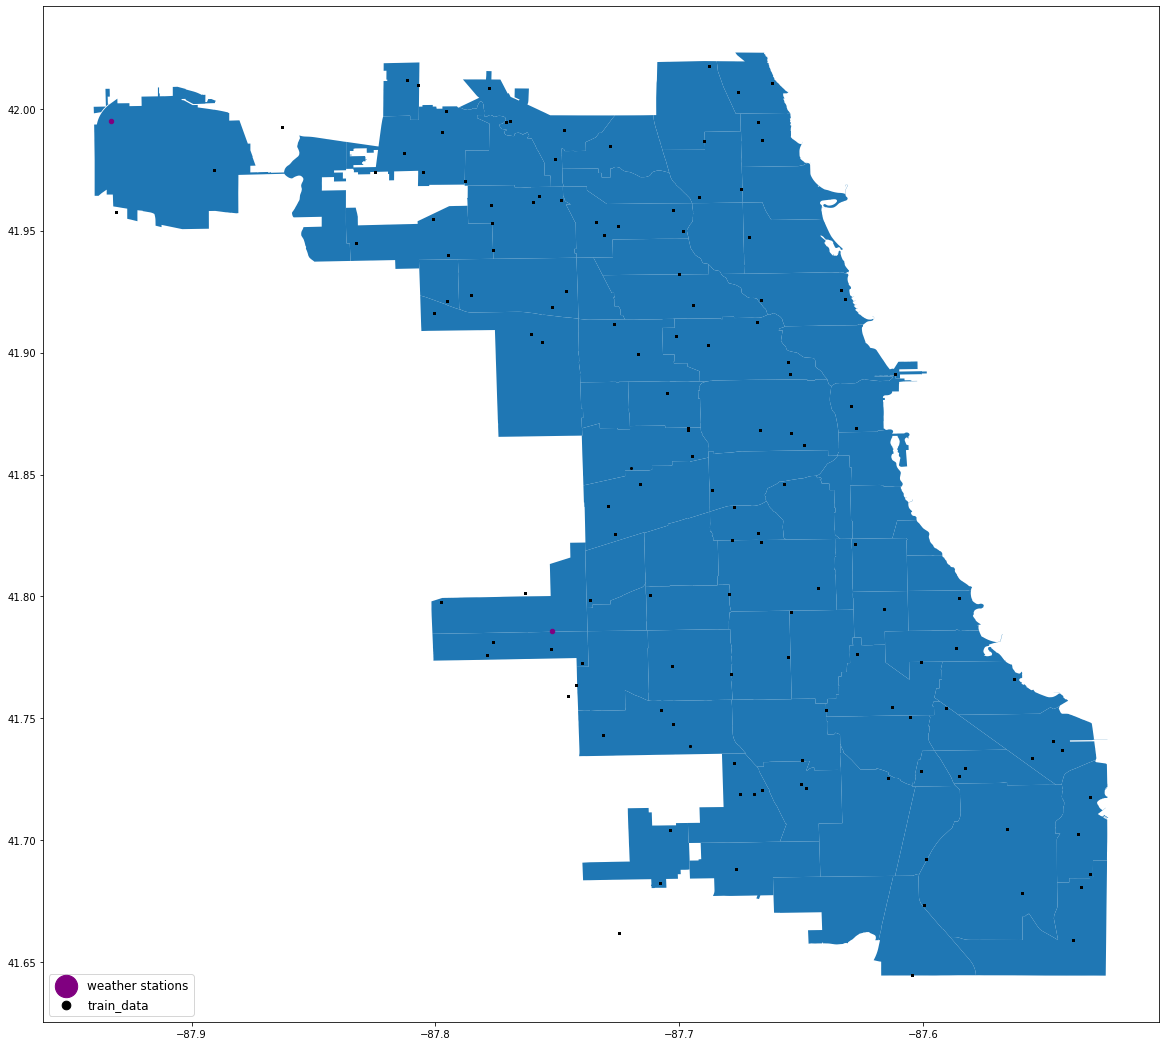

In [15]:
#plot data to the map
dict_df = {'train_data':df_train           
          }
plot_geodata(dict_df)

#### test data

In [16]:
df_test = pd.read_csv("../assets/test.csv")
df_test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9


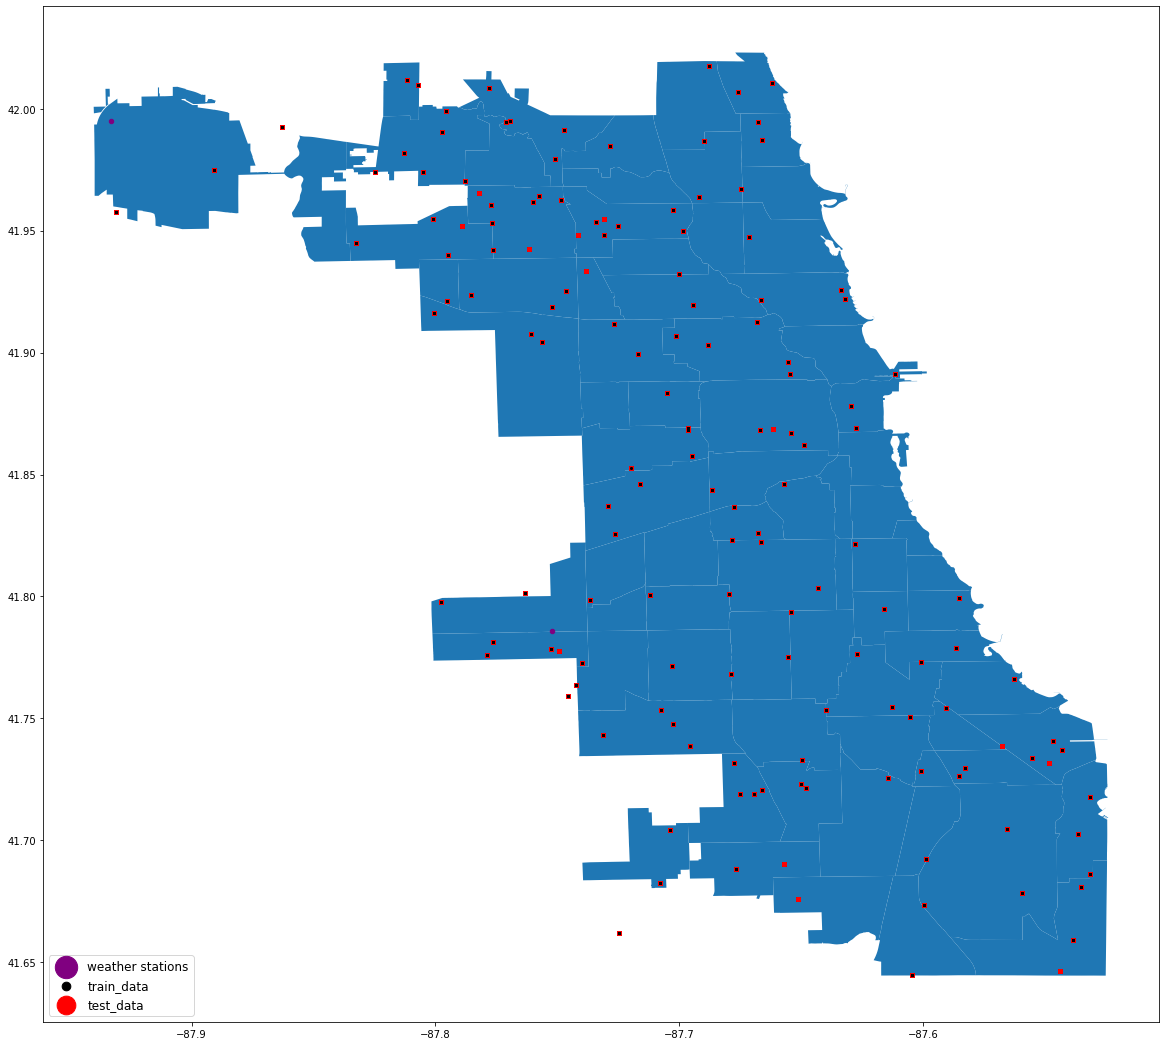

In [17]:
dict_df = {'train_data':df_train, 
           'test_data':df_test,
          }
plot_geodata(dict_df)


#### spray data

In [18]:
df_spray = pd.read_csv("../assets/spray.csv")
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.39,-88.09
1,2011-08-29,6:57:08 PM,42.39,-88.09
2,2011-08-29,6:57:18 PM,42.39,-88.09
3,2011-08-29,6:57:28 PM,42.39,-88.09
4,2011-08-29,6:57:38 PM,42.39,-88.09


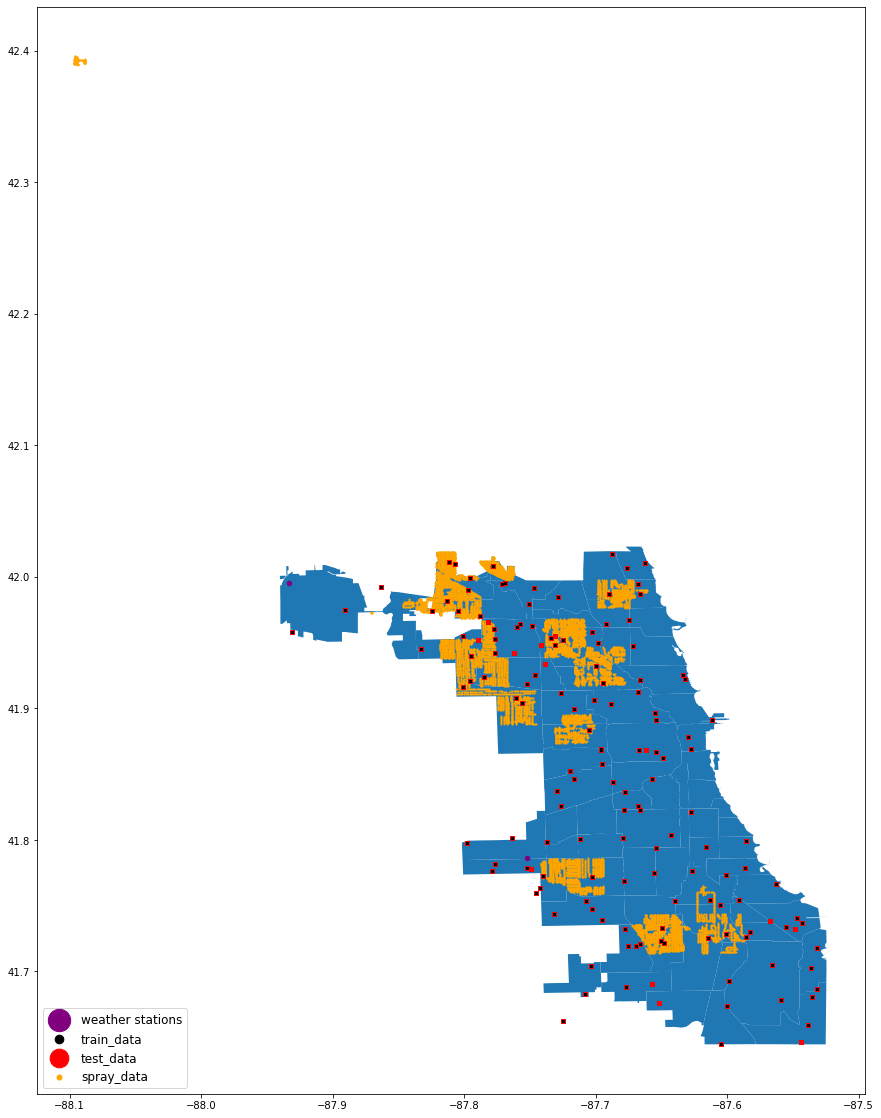

In [19]:
dict_df = {'train_data':df_train, 
           'test_data':df_test,
           'spray_data':df_spray,
           
          }
plot_geodata(dict_df)


**we only consider the spray data close to those traps, whose latitude are all below 42.3**

In [20]:
df_spray = df_spray.query("Latitude < 42.3")

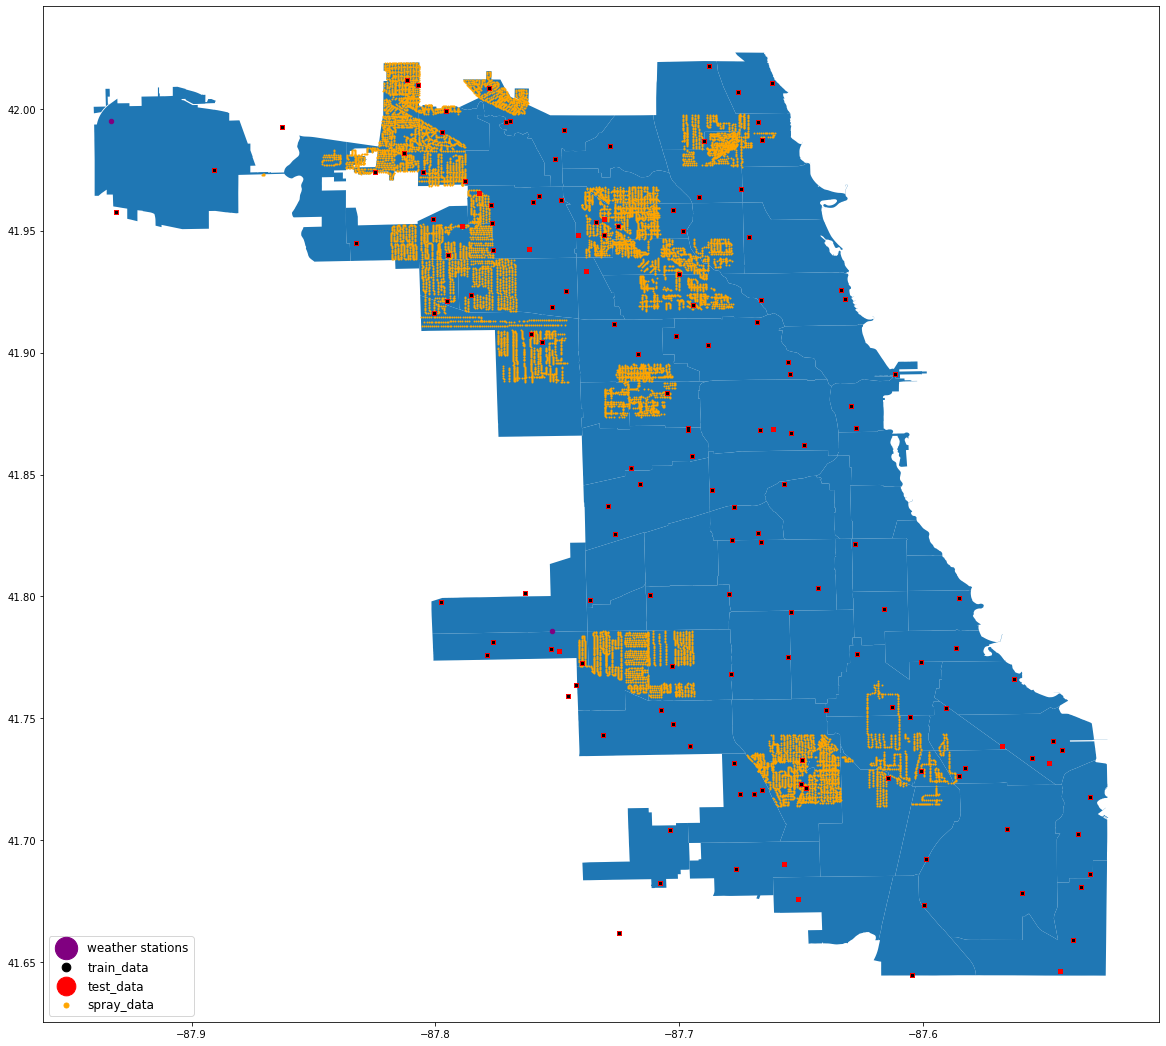

In [21]:
#plot data to the map
dict_df = {'train_data':df_train, 
           'test_data':df_test,
           'spray_data':df_spray,
           
          }
plot_geodata(dict_df)


#### weather data

In [22]:
df_weather = pd.read_csv("../assets/weather.csv")
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.70,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.70,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.00,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.30,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.70,7,11.9


# Further Data Cleaning
We will check and handle:
- null values
- invalid values
- potential outliers

#### **df_train**

In [23]:
#check null values
df_train.isnull().sum().sort_values(ascending=False)

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
geometry                  0
dtype: int64

In [24]:

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Date                    10506 non-null  object  
 1   Address                 10506 non-null  object  
 2   Species                 10506 non-null  object  
 3   Block                   10506 non-null  int64   
 4   Street                  10506 non-null  object  
 5   Trap                    10506 non-null  object  
 6   AddressNumberAndStreet  10506 non-null  object  
 7   Latitude                10506 non-null  float64 
 8   Longitude               10506 non-null  float64 
 9   AddressAccuracy         10506 non-null  int64   
 10  NumMosquitos            10506 non-null  int64   
 11  WnvPresent              10506 non-null  int64   
 12  geometry                10506 non-null  geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 1.0+ MB


In [25]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  geometry                10506 non-null  geomet

**clean df_test**

In [26]:
df_test.isnull().sum().sort_values(ascending=False)

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
geometry                  0
dtype: int64

In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   Id                      116293 non-null  int64   
 1   Date                    116293 non-null  object  
 2   Address                 116293 non-null  object  
 3   Species                 116293 non-null  object  
 4   Block                   116293 non-null  int64   
 5   Street                  116293 non-null  object  
 6   Trap                    116293 non-null  object  
 7   AddressNumberAndStreet  116293 non-null  object  
 8   Latitude                116293 non-null  float64 
 9   Longitude               116293 non-null  float64 
 10  AddressAccuracy         116293 non-null  int64   
 11  geometry                116293 non-null  geometry
dtypes: float64(2), geometry(1), int64(3), object(6)
memory usage: 10.6+ MB


In [28]:
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  geometry                116293 non-null  geometry      
dtypes: datetime64[ns](1), float64(

**clean df_spray**

In [29]:
df_spray.isnull().sum().sort_values(ascending=False)

Time         584
Date           0
Latitude       0
Longitude      0
geometry       0
dtype: int64

In [30]:
df_spray.shape

(14740, 5)

In [31]:
df_spray.head(20)

,Date,Time,Latitude,Longitude,geometry
95,2011-09-07,7:52:52 PM,41.98,-87.79,POINT (-87.78778 41.98143)
96,2011-09-07,7:53:02 PM,41.98,-87.79,POINT (-87.78778 41.98100)
97,2011-09-07,7:53:12 PM,41.98,-87.79,POINT (-87.78776 41.98056)
98,2011-09-07,7:53:22 PM,41.98,-87.79,POINT (-87.78776 41.98020)
99,2011-09-07,7:53:32 PM,41.98,-87.79,POINT (-87.78776 41.97975)
100,2011-09-07,7:53:42 PM,41.98,-87.79,POINT (-87.78775 41.97935)
101,2011-09-07,7:53:52 PM,41.98,-87.79,POINT (-87.78776 41.97885)
102,2011-09-07,7:54:02 PM,41.98,-87.79,POINT (-87.78777 41.97840)
103,2011-09-07,7:54:12 PM,41.98,-87.79,POINT (-87.78776 41.97799)
104,2011-09-07,7:54:22 PM,41.98,-87.79,POINT (-87.78778 41.97749)


In [32]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14740 entries, 95 to 14834
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Date       14740 non-null  object  
 1   Time       14156 non-null  object  
 2   Latitude   14740 non-null  float64 
 3   Longitude  14740 non-null  float64 
 4   geometry   14740 non-null  geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 690.9+ KB


In [33]:
df_spray['Date']=pd.to_datetime(df_spray['Date'])
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14740 entries, 95 to 14834
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14740 non-null  datetime64[ns]
 1   Time       14156 non-null  object        
 2   Latitude   14740 non-null  float64       
 3   Longitude  14740 non-null  float64       
 4   geometry   14740 non-null  geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), object(1)
memory usage: 690.9+ KB


**clean df_weather**

In [34]:
df_weather.isnull().sum().sort_values(ascending=False)

Station        0
Date           0
ResultDir      0
ResultSpeed    0
SeaLevel       0
StnPressure    0
PrecipTotal    0
SnowFall       0
Water1         0
Depth          0
CodeSum        0
Sunset         0
Sunrise        0
Cool           0
Heat           0
WetBulb        0
DewPoint       0
Depart         0
Tavg           0
Tmin           0
Tmax           0
AvgSpeed       0
dtype: int64

In [35]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [36]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [37]:
df_weather['Tavg'].value_counts()

73    138
77    117
70    117
75    110
71    109
74    107
72    104
69    103
78    102
76    100
68     99
79     98
66     93
67     89
61     88
64     86
80     84
65     84
63     81
57     67
62     66
60     61
50     57
81     55
53     49
58     49
54     48
82     48
55     48
56     46
52     46
59     45
51     36
83     34
49     29
45     28
47     24
46     24
84     21
44     19
48     17
85     16
86     16
42     15
43     12
M      11
87      9
41      7
40      5
39      4
89      4
88      4
91      4
37      2
38      2
90      2
36      2
92      1
93      1
94      1
Name: Tavg, dtype: int64

In [38]:
df_weather.query("Tavg == 'M'")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.10,7,10.4
505,2,2008-07-08,86,46,M,M,68,71,M,M,-,-,TS RA,M,M,M,0.28,29.16,29.80,7.40,24,8.3
675,2,2008-10-01,62,46,M,M,41,47,M,M,-,-,,M,M,M,0.00,29.30,29.96,10.90,33,11.0
1637,2,2011-07-22,100,71,M,M,70,74,M,M,-,-,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.80,10,8.2
2067,2,2012-08-22,84,72,M,M,51,61,M,M,-,-,,M,M,M,0.00,29.39,M,4.70,19,M
2211,2,2013-05-02,71,42,M,M,39,45,M,M,-,-,,M,M,M,0.00,29.51,30.17,15.80,2,16.1
2501,2,2013-09-24,91,52,M,M,48,54,M,M,-,-,,M,M,M,0.00,29.33,30.00,5.80,9,7.7
2511,2,2013-09-29,84,53,M,M,48,54,M,M,-,-,RA BR,M,M,M,0.22,29.36,30.01,6.30,36,7.8
2525,2,2013-10-06,76,48,M,M,44,50,M,M,-,-,RA DZ BR,M,M,M,0.06,29.10,29.76,10.10,25,10.6
2579,2,2014-05-02,80,47,M,M,43,47,M,M,-,-,RA,M,M,M,0.04,29.10,29.79,10.70,23,11.9


In [39]:
df_weather['Tavg']=np.where(df_weather['Tavg']=='M', (df_weather['Tmax']+df_weather['Tmin'])/2, df_weather['Tavg'])
df_weather['Tavg']=df_weather['Tavg'].astype(float)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [40]:
df_weather['Water1'].value_counts()

M    2944
Name: Water1, dtype: int64

In [41]:
df_weather['PrecipTotal'].value_counts()

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
0.04      36
0.05      32
0.08      28
0.12      28
0.06      27
0.07      23
0.16      21
0.09      21
0.11      20
0.14      20
0.17      17
0.28      15
0.13      14
0.19      14
0.18      14
0.20      13
0.15      13
0.23      11
0.25      11
0.26      11
0.10      10
0.24      10
0.31       9
0.39       9
0.40       9
0.21       9
0.29       9
0.43       9
0.34       8
0.32       8
0.22       8
0.33       7
0.41       7
0.50       7
0.48       7
0.37       7
0.45       7
0.59       7
0.30       7
0.80       6
0.63       6
0.84       6
0.65       6
0.27       6
0.92       5
0.68       5
0.44       5
0.36       5
0.54       5
0.93       5
0.85       5
1.23       4
0.72       4
0.75       4
0.64       4
0.52       4
0.70       4
0.55       4
0.97       4
0.51       4
0.58       4
0.89       4
0.66       4
0.87       3
0.60       3
1.31       3
1.05       3
1.01       3
0.77       3
1.03       3
0.56       3
0.88       3

Special symbols

Symbols that appear on many of the individual summaries: (*) less than one half; (T ) trace, an amount too small to measure; (—) below zero temperatures are preceded by a minus sign.
Weather averages year-by-year

PRECIPITATION refers to the inches of water equivalent in the total of all forms of liquid or frozen precipitation that fell during each month. Snowfall refers to the actual amount of snow in inches that fell during the month. T (trace) is a precipitation amount of less than 0.005 in (note: in estimating the water equivalent of snow a ratio of 10 in of snow equal 1 in of water is customarily employed).
https://www.encyclopedia.com/environment/encyclopedias-almanacs-transcripts-and-maps/local-climatological-data-reports


In [42]:
df_weather['PrecipTotal']=np.where(df_weather['PrecipTotal'].str.strip() =='T', 0.005, df_weather['PrecipTotal'] )
df_weather['PrecipTotal']=np.where(df_weather['PrecipTotal'].str.strip() =='M', 0, df_weather['PrecipTotal'] )
df_weather['PrecipTotal']=df_weather['PrecipTotal'].astype(float)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

**split df_weather into 2 dataframes according to weather stations**

In [43]:
df_weather_1=df_weather.query("Station == 1")
df_weather_1.set_index("Date", inplace=True)
df_weather_1.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.00,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.70,27,9.2
2007-05-02,1,59,42,51.00,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.00,4,13.4
2007-05-03,1,66,46,56.00,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.70,7,11.9
2007-05-04,1,66,49,58.00,4,41,50,7,0,0444,1852,RA,0,M,0.0,0.01,29.31,30.05,10.40,8,10.8
2007-05-05,1,66,53,60.00,5,38,49,5,0,0443,1853,,0,M,0.0,0.01,29.40,30.10,11.70,7,12.0


**try to find out the day lenght for 2 stations**

**df_weather_1**

In [44]:
#convert datatype
df_weather_1['Sunset'] = df_weather_1['Sunset'].astype(int)

In [45]:
df_weather_1['Sunrise'].value_counts()

0416    104
0417     64
0419     40
0420     32
0418     32
0422     32
0425     32
0421     24
0423     24
0433     24
0428     24
0429     16
0447     16
0424     16
0426     16
0427     16
0448     16
0430     16
0439     16
0446     16
0431     16
0444     16
0443     16
0441     16
0442     16
0438     16
0437     16
0436     16
0435     16
0434     16
0432     16
0555      8
0546      8
0554      8
0553      8
0552      8
0550      8
0549      8
0548      8
0547      8
0539      8
0545      8
0544      8
0543      8
0542      8
0541      8
0540      8
0538      8
0537      8
0536      8
0557      8
0556      8
0614      8
0558      8
0559      8
0622      8
0620      8
0619      8
0618      8
0617      8
0616      8
0533      8
0613      8
0612      8
0611      8
0610      8
0608      8
0607      8
0606      8
0605      8
0604      8
0603      8
0602      8
0600      8
0535      8
0517      8
0532      8
0508      8
0505      8
0504      8
0503      8
0502      8
0501      8
0500

In [46]:
df_weather_1['Sunrise'] = df_weather_1['Sunrise'].astype(int)
df_weather_1['Day_length'] =((df_weather_1['Sunset']//100*60+df_weather_1['Sunset']%100)
                                 - (df_weather_1['Sunrise']//100*60+df_weather_1['Sunrise']%100)
                               )/60 
df_weather_1[['Sunrise','Sunset','Day_length']].head(10)

,Sunrise,Sunset,Day_length
Date,,,
2007-05-01,448,1849,14.02
2007-05-02,447,1850,14.05
2007-05-03,446,1851,14.08
2007-05-04,444,1852,14.13
2007-05-05,443,1853,14.17
2007-05-06,442,1855,14.22
2007-05-07,441,1856,14.25
2007-05-08,439,1857,14.30
2007-05-09,438,1858,14.33


**df_weather_2**

In [47]:
df_weather_2=df_weather.query("Station == 2")
df_weather_2.set_index("Date", inplace=True)

In [48]:
#copy the 'Sunrise', 'Sunset' and 'Day_length' from df_weather_1 to df_weather_2
df_weather_2.loc[:,'Sunrise'] = np.where(True, df_weather_1['Sunrise'],0)
df_weather_2.loc[:,'Sunset'] = np.where(True,df_weather_1['Sunset'],0)
df_weather_2.loc[:,'Day_length'] = np.where(True,df_weather_1['Day_length'],0)
df_weather_2.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day_length
Date,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,2,84,52,68.00,M,51,57,0,3,448,1849,,M,M,M,0.00,29.18,29.82,2.70,25,9.6,14.02
2007-05-02,2,60,43,52.00,M,42,47,13,0,447,1850,BR HZ,M,M,M,0.00,29.44,30.08,13.30,2,13.4,14.05
2007-05-03,2,67,48,58.00,M,40,50,7,0,446,1851,HZ,M,M,M,0.00,29.46,30.12,12.90,6,13.2,14.08
2007-05-04,2,78,51,64.50,M,42,50,M,M,444,1852,,M,M,M,0.00,29.36,30.04,10.10,7,10.4,14.13
2007-05-05,2,66,54,60.00,M,39,50,5,0,443,1853,,M,M,M,0.01,29.46,30.09,11.20,7,11.5,14.17


# EDA
- 

**Mosquito Species Analysis**

In [49]:
df_train['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [50]:
df_test['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

             ploting NumMosquitos and WnvPresent of different species


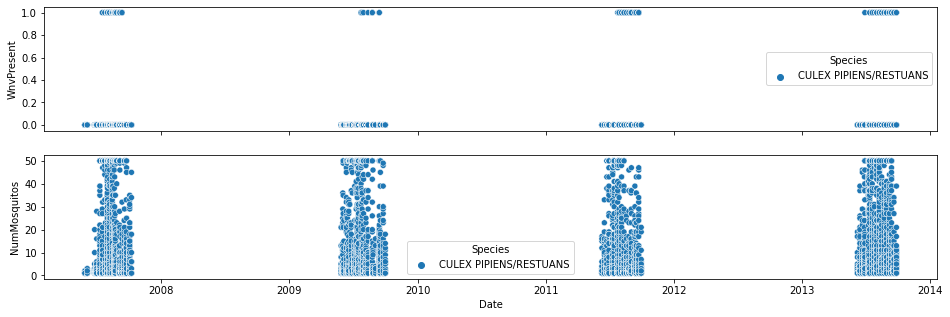

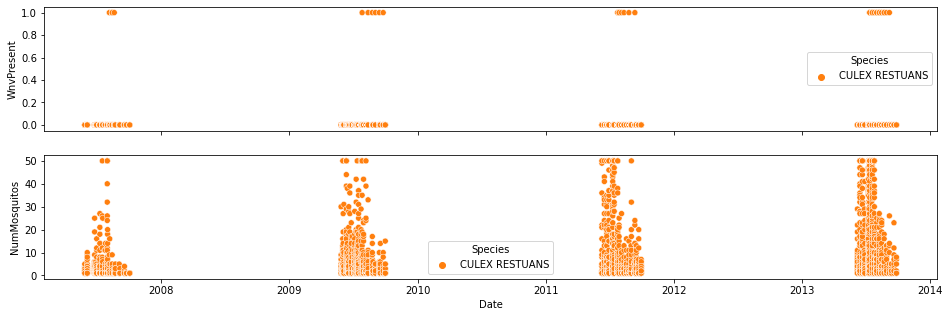

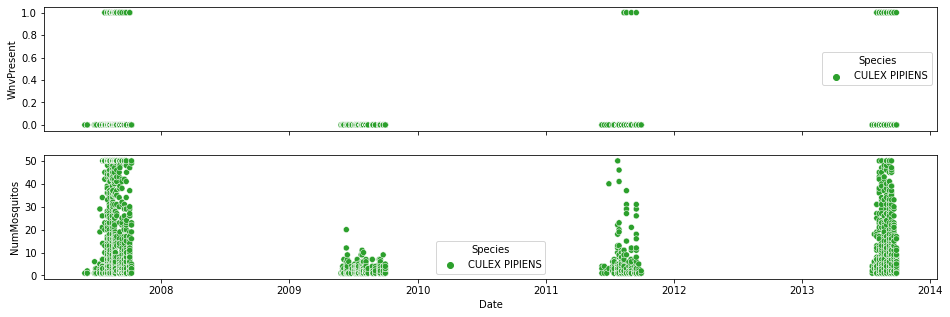

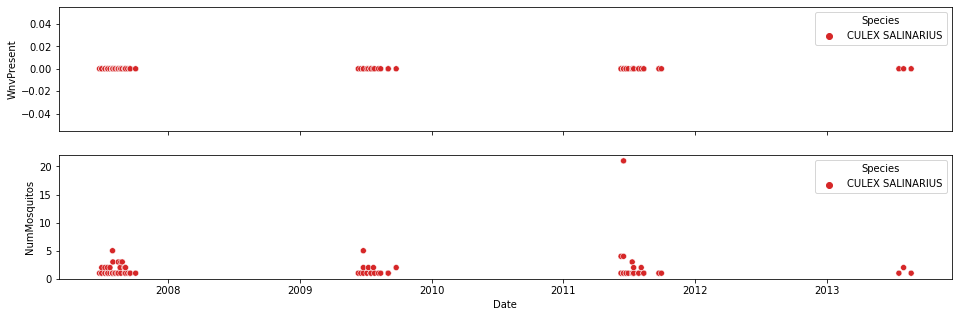

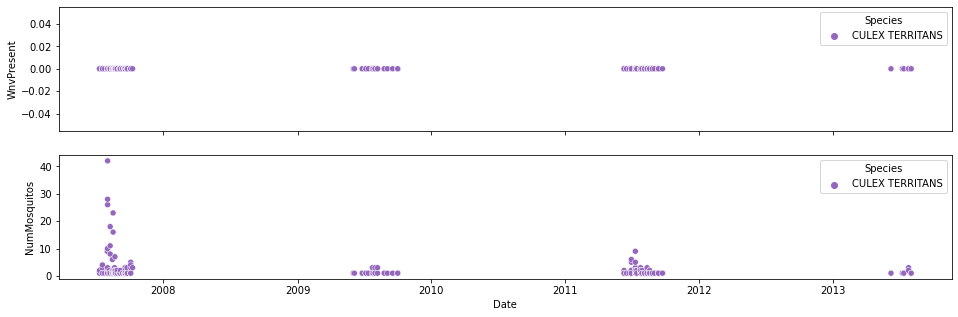

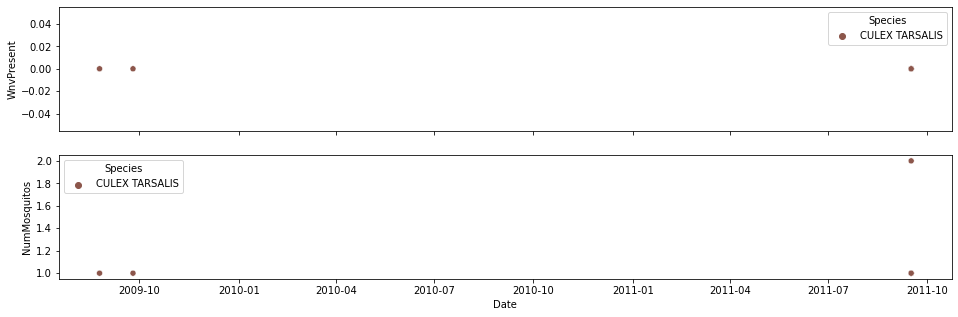

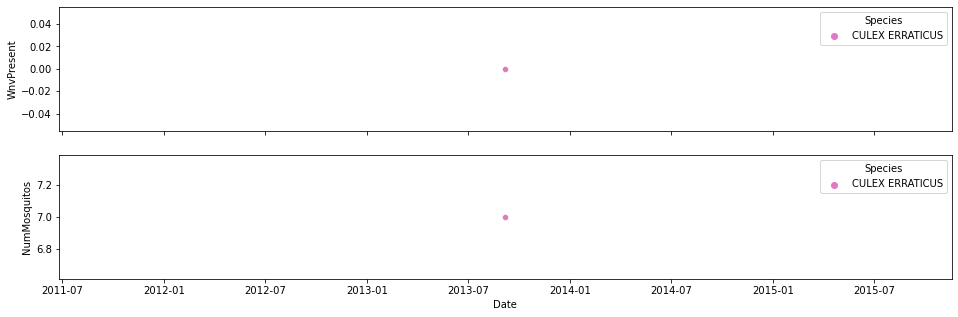

In [51]:
#plot NumMosquitos and WnvPresent of different species
df1 = df_train
df1 = df1.set_index("Date")
species = df1['Species'].unique().tolist()
print('             ploting NumMosquitos and WnvPresent of different species')
for i in range(len(species)):
    df = df1[df1["Species"] == species[i]]
    palette ={'CULEX PIPIENS/RESTUANS': "C0",
              'CULEX RESTUANS': "C1", 
              'CULEX PIPIENS': "C2", 
              'CULEX SALINARIUS': "C3",
              'CULEX TERRITANS': "C4", 
              'CULEX TARSALIS': "C5", 
              'CULEX ERRATICUS': "C6", 
              'UNSPECIFIED CULEX': "C7"
             }
   # print(species[i])
    #palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
    fig,ax=plt.subplots(2,sharex='col',figsize=(16,5))
    #df['WnvPresent'].plot(kind='area', ax=ax[0])
    sns.scatterplot(data=df,x=df.index, y='WnvPresent',hue='Species',ax=ax[0],palette=palette)
    #df['NumMosquitos'].plot(kind='area', ax=ax[1])
    sns.scatterplot(data=df,x=df.index, y='NumMosquitos',hue='Species',ax=ax[1],palette=palette)

**Observations**:
- West Nile Virus is founded in 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS' only, thus we can group the other species as one group for convenience
- the popultion of 'CULEX PIPIENS' varied in different years

**NumMosquitos vs. WnvPresent**

In [52]:
df_wnvpresent = df_train.query("WnvPresent==1")
df_not_wnvpresent = df_train.query("WnvPresent==0")

<AxesSubplot:xlabel='NumMosquitos', ylabel='Count'>

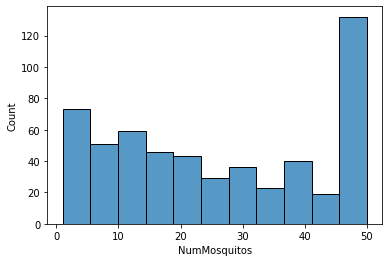

In [53]:
sns.histplot(data=df_wnvpresent, x='NumMosquitos')

<AxesSubplot:xlabel='NumMosquitos', ylabel='Count'>

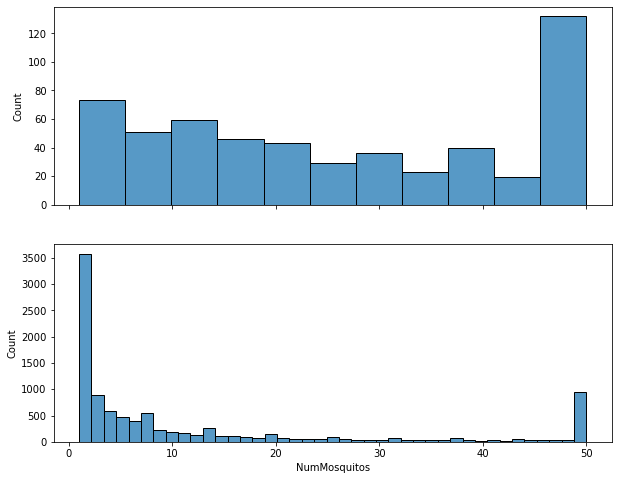

In [54]:
fig,ax=plt.subplots(2,sharex='col',figsize=(10,8))
#df['WnvPresent'].plot(kind='area', ax=ax[0])
sns.histplot(data=df_wnvpresent, x='NumMosquitos',ax=ax[0])
sns.histplot(data=df_not_wnvpresent, x='NumMosquitos',ax=ax[1])

In [55]:
df_train.groupby(['Species']).mean()['WnvPresent']

Species
CULEX ERRATICUS          0.00
CULEX PIPIENS            0.09
CULEX PIPIENS/RESTUANS   0.06
CULEX RESTUANS           0.02
CULEX SALINARIUS         0.00
CULEX TARSALIS           0.00
CULEX TERRITANS          0.00
Name: WnvPresent, dtype: float64

#### EDA df_weather_2

<AxesSubplot:xlabel='Date'>

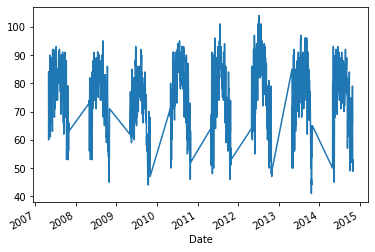

In [56]:
df_weather_2['Tmax'].plot()

<AxesSubplot:xlabel='Date'>

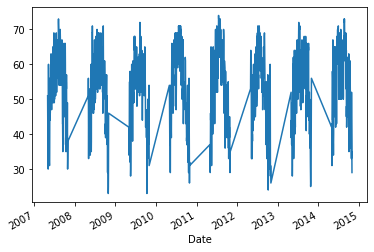

In [57]:
df_weather_2['DewPoint'].plot()

<AxesSubplot:xlabel='Date'>

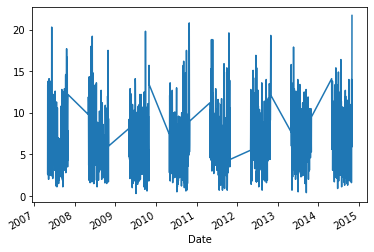

In [58]:
df_weather_2['ResultSpeed'].plot()

<AxesSubplot:xlabel='Date'>

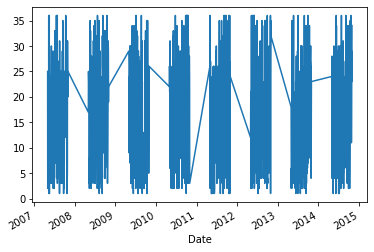

In [59]:
df_weather_2['ResultDir'].plot()

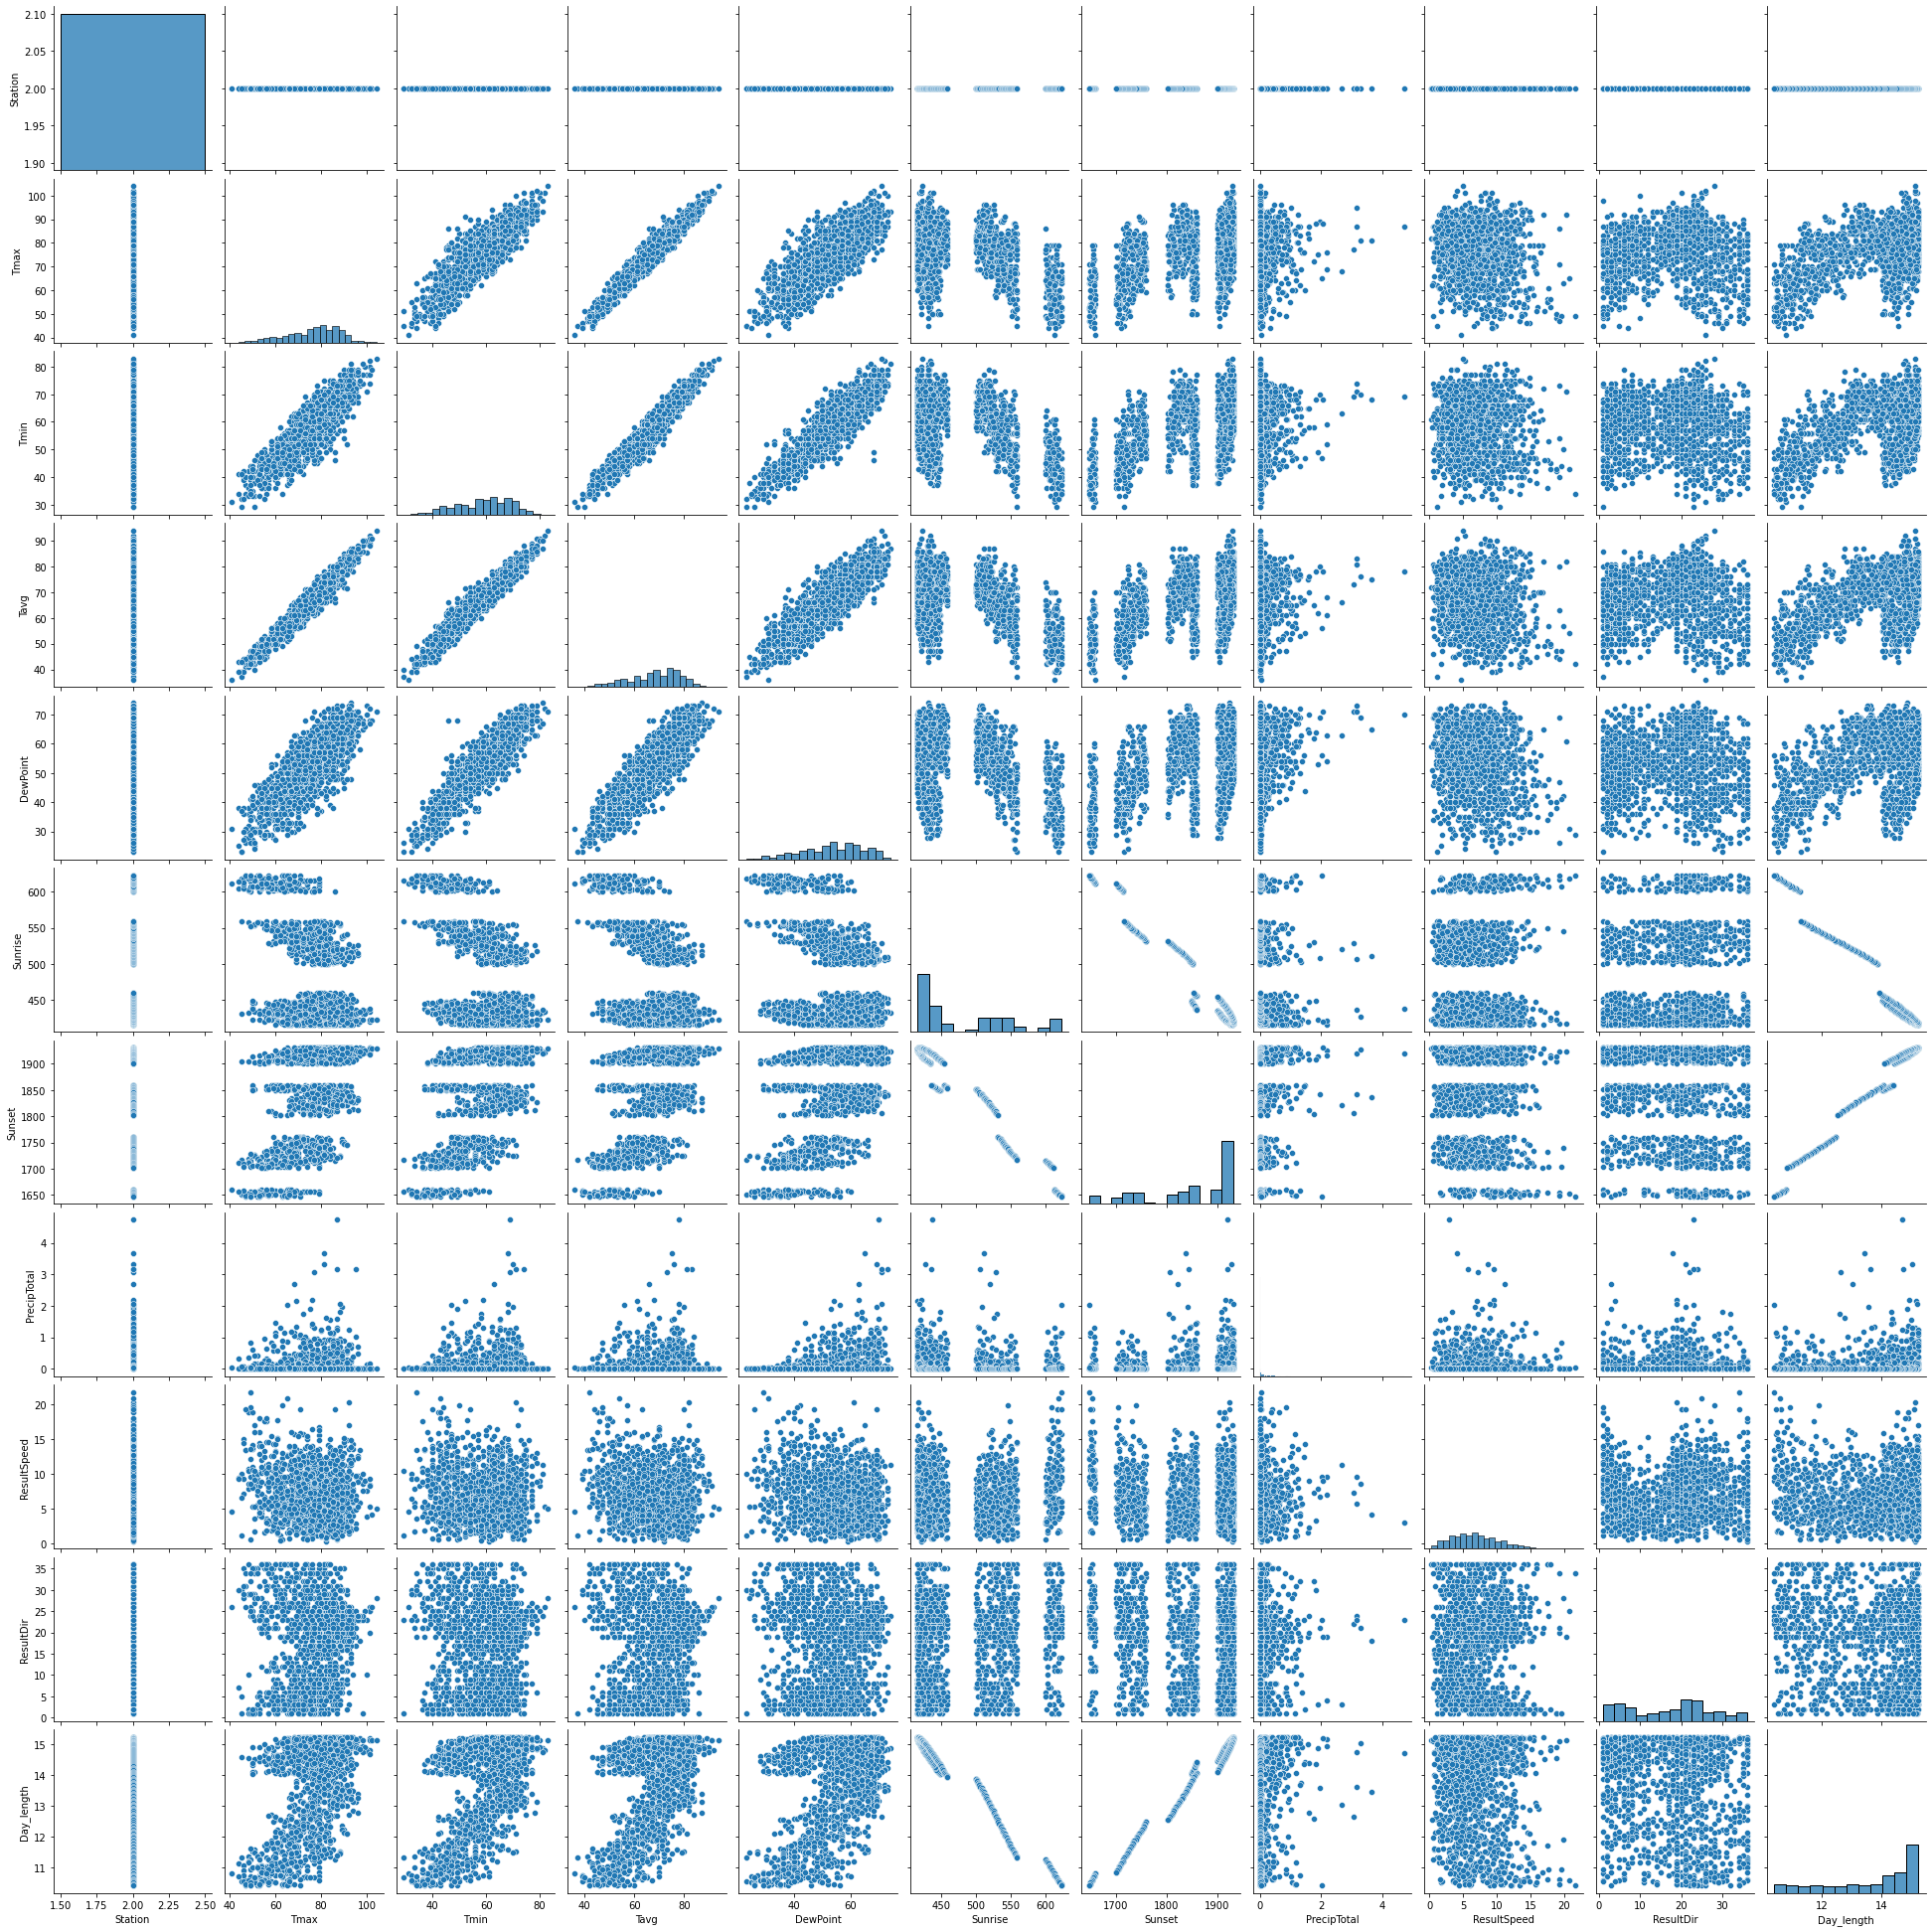

In [60]:
sns.pairplot(df_weather_2)

# Feature Engineering
- "Species": 
    - all species which dont carry virus will be regrouped to 'OTHERS'
    - convert this categorical feature into dummy variables 
- "Trap":
    - cluster all traps based on their locations
    - convert this categorical feature into dummy variables 
- weather data
    - decide weather_features to shift, to rolling-mean, and to rolling-sum
    - add those weather_features to training set

**"Species"**: 
   - all species which dont carry virus will be regrouped to 'OTHERS'
   - convert this categorical feature into dummy variables 

In [61]:
df_train.loc[:,['Species']] = np.where(df_train['Species'].isin(['CULEX PIPIENS','CULEX PIPIENS/RESTUANS','CULEX RESTUANS']),
                                      df_train['Species'],
                                      'OTHERS')
#for test submission
df_test.loc[:,['Species']] = np.where(df_test['Species'].isin(['CULEX PIPIENS','CULEX PIPIENS/RESTUANS','CULEX RESTUANS']),
                                      df_test['Species'],
                                      'OTHERS')

In [62]:
df_train = pd.get_dummies(columns=["Species"], data=df_train, drop_first=True)

#for test submission
df_test = pd.get_dummies(columns=["Species"], data=df_test, drop_first=True)

**cluster traps**
   - cluster all traps based on their locations
   - convert this categorical feature into dummy variables 

<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

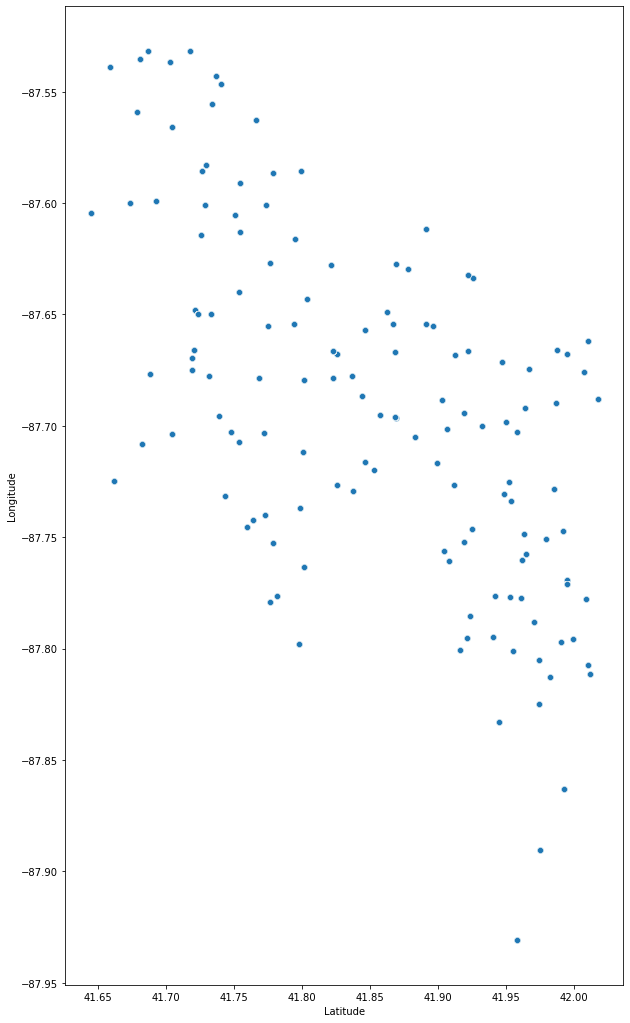

In [63]:
#plot all traps locations
fig,ax=plt.subplots(1,figsize=(10,18))
sns.scatterplot(data=df_train, x='Latitude',y='Longitude',ax=ax, palette="muted")

In [64]:
# Let's prepare our X matrix
X = df_train.loc[:, ['Latitude', 'Longitude']]

#for test submission
X_test = df_test.loc[:, ['Latitude', 'Longitude']]


In [65]:
km = KMeans(n_clusters=30, random_state=42)
km.fit(X)

KMeans(n_clusters=30, random_state=42)

In [66]:
# Check out centroids
km.cluster_centers_

array([[ 41.97671976, -87.74650368],
       [ 41.76410356, -87.60413316],
       [ 41.9764036 , -87.88795283],
       [ 41.81609879, -87.6731264 ],
       [ 41.72610751, -87.65870889],
       [ 41.692987  , -87.562828  ],
       [ 41.89336897, -87.654814  ],
       [ 41.91287139, -87.74556978],
       [ 41.78789927, -87.76624012],
       [ 41.95935416, -87.80618051],
       [ 41.99959506, -87.67910765],
       [ 41.662014  , -87.724608  ],
       [ 41.72694528, -87.58945653],
       [ 41.80955606, -87.72762192],
       [ 41.67338941, -87.59995427],
       [ 41.90941666, -87.67818734],
       [ 41.75351024, -87.73693499],
       [ 42.00509324, -87.78956703],
       [ 41.8593489 , -87.701687  ],
       [ 41.91189618, -87.70641409],
       [ 41.76802369, -87.69394015],
       [ 41.92435454, -87.79390506],
       [ 41.957799  , -87.930995  ],
       [ 41.91768068, -87.62919107],
       [ 41.74459434, -87.55102995],
       [ 41.69017459, -87.69846825],
       [ 41.67994474, -87.5360626 ],
 

In [67]:
df_train['trap_cluster']=km.labels_

#for test submission
df_test['trap_cluster']=km.predict(X_test)


<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

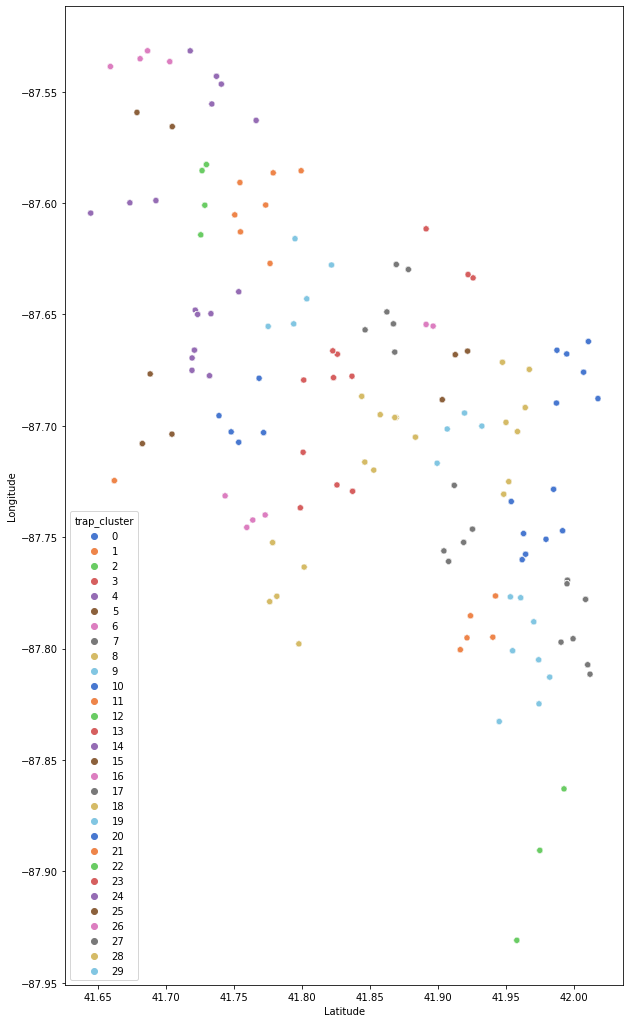

In [68]:
fig,ax=plt.subplots(1,figsize=(10,18))
sns.scatterplot(data=df_train, x='Latitude',y='Longitude', hue='trap_cluster',ax=ax, palette="muted")

**convert the trap clusters into dummy variables**

In [69]:
df_train = pd.get_dummies(columns=["trap_cluster"], data=df_train, drop_first=True)

#for test submission
df_test = pd.get_dummies(columns=["trap_cluster"], data=df_test, drop_first=True)

**create new column 'Station', indicating which station a trap is closer to**

In [70]:
df_train['Station']= df_train.apply(near_station, axis=1)

#for test submission
df_test['Station']= df_test.apply(near_station, axis=1)

**merge weather data to training set**
- decide weather_features to shift, to rolling-mean, and to rolling-sum
- add those weather_features to training set

In [71]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            10506 non-null  datetime64[ns]
 1   Address                         10506 non-null  object        
 2   Block                           10506 non-null  int64         
 3   Street                          10506 non-null  object        
 4   Trap                            10506 non-null  object        
 5   AddressNumberAndStreet          10506 non-null  object        
 6   Latitude                        10506 non-null  float64       
 7   Longitude                       10506 non-null  float64       
 8   AddressAccuracy                 10506 non-null  int64         
 9   NumMosquitos                    10506 non-null  int64         
 10  WnvPresent                      10506 non-null  int64         
 11  ge

In [72]:
df_weather_1.index

DatetimeIndex(['2007-05-01', '2007-05-02', '2007-05-03', '2007-05-04',
               '2007-05-05', '2007-05-06', '2007-05-07', '2007-05-08',
               '2007-05-09', '2007-05-10',
               ...
               '2014-10-22', '2014-10-23', '2014-10-24', '2014-10-25',
               '2014-10-26', '2014-10-27', '2014-10-28', '2014-10-29',
               '2014-10-30', '2014-10-31'],
              dtype='datetime64[ns]', name='Date', length=1472, freq=None)

In [73]:
df_weather_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      1472 non-null   int64  
 1   Tmax         1472 non-null   int64  
 2   Tmin         1472 non-null   int64  
 3   Tavg         1472 non-null   float64
 4   Depart       1472 non-null   object 
 5   DewPoint     1472 non-null   int64  
 6   WetBulb      1472 non-null   object 
 7   Heat         1472 non-null   object 
 8   Cool         1472 non-null   object 
 9   Sunrise      1472 non-null   int32  
 10  Sunset       1472 non-null   int32  
 11  CodeSum      1472 non-null   object 
 12  Depth        1472 non-null   object 
 13  Water1       1472 non-null   object 
 14  SnowFall     1472 non-null   object 
 15  PrecipTotal  1472 non-null   float64
 16  StnPressure  1472 non-null   object 
 17  SeaLevel     1472 non-null   object 
 18  ResultSpeed  1472 non-null   f

In [74]:
k1=6
weather_features_shift = { "Tmax" : k1,  
                              "Tmin" : k1,
                              "Tavg" : k1,
                              'DewPoint' :k1,
                              "Sunrise" : k1,
                              "Sunset"  : k1,
                             'Day_length' : k1,
                             'PrecipTotal' : k1,
                             'ResultSpeed' : k1
                           }
    
    
k2 = 12
weather_features_rollingmean = { "Tmax" : k2,  
                             "Tmin" : k2,
                             "Tavg" : k2,
                             'DewPoint' :k2,
                             "Sunrise" : k2,
                             "Sunset"  : k2,
                             'Day_length' : k2,
                             'PrecipTotal' : k2,
                             'ResultSpeed' : k2
                           }

k3 = 14
weather_features_rollingSum = {  "Tmax" : k3,  
                                 "Tmin" : k3,
                                 "Tavg" : k3,
                                 'DewPoint' :k3,
                                 "Sunrise" : k3,
                                 "Sunset"  : k3,
                                 'Day_length' : k3,
                                 'PrecipTotal' : k3,
                                 'ResultSpeed' : k3
                           }

df_final = add_weather_features(df_train, 
                                weather_features_shift,
                                weather_features_rollingmean,
                                weather_features_rollingSum)


#for test submission
df_final_submission = add_weather_features(df_test, 
                                weather_features_shift,
                                weather_features_rollingmean,
                                weather_features_rollingSum)

In [81]:
df_final.head().T

id_,0,1,2,3,4
Date,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,...","6200 North Mandell Avenue, Chicago, IL 60646, USA","7900 West Foster Avenue, Chicago, IL 60656, USA","7900 West Foster Avenue, Chicago, IL 60656, USA"
Block,41,41,62,79,79
Street,N OAK PARK AVE,N OAK PARK AVE,N MANDELL AVE,W FOSTER AVE,W FOSTER AVE
Trap,T002,T002,T007,T015,T015
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL","6200 N MANDELL AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL"
Latitude,41.95,41.95,41.99,41.97,41.97
Longitude,-87.80,-87.80,-87.77,-87.82,-87.82
AddressAccuracy,9,9,9,8,8
NumMosquitos,1,1,1,1,4


# Data Preparation

In [76]:

columns_to_drop = ['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 
                            'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'geometry','Station']

X = df_final.drop(columns=columns_to_drop)
y = df_final['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=100, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=100, shuffle=False)





#for test submission
columns_to_drop_submission = ['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 
                            'Latitude', 'Longitude', 'AddressAccuracy', 'geometry','Station', 'Id']

X_submission =  df_final_submission.drop(columns=columns_to_drop_submission)


# Modelling
- oversampling and undersampling
- run model
- evaluate performance

### Model: GradientBoostingClassifier

best_params: 
    classifier__max_depth  :  2
    classifier__n_estimators  :  500

roc_auc_score on training set: 0.901
roc_auc_score on testing set: 0.825
perc_diff: 8.4 %


f1_score on training set: 0.336
f1_score on testing set: 0.259
perc_diff: 22.8 %

confusion matrix: 
                   pred No virus  pred WnvPresent
actual No virus             2467              520
actual WnvPresent             63              102

plot confusion matrix and ROC curve


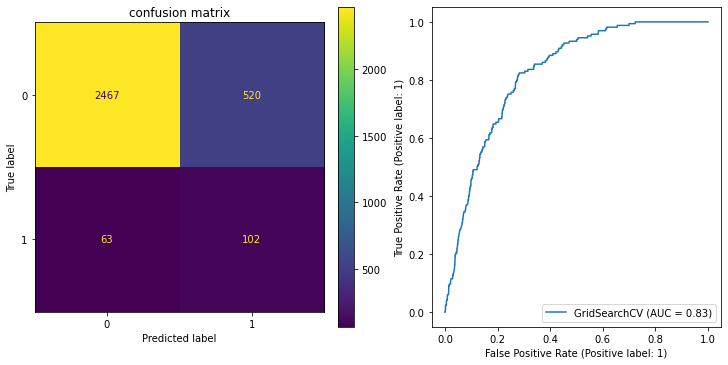

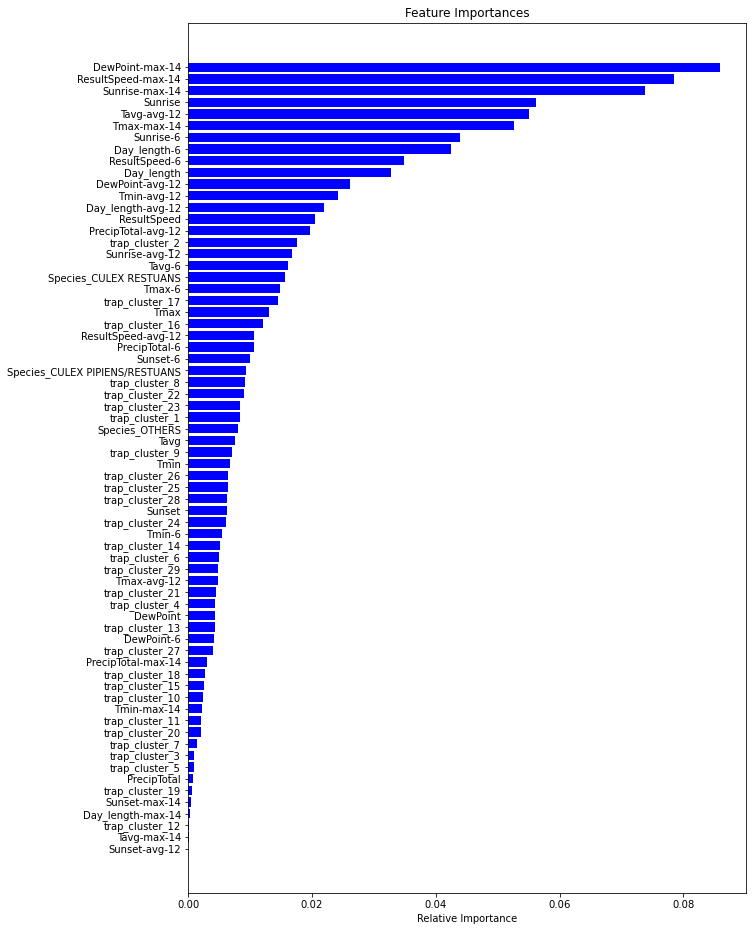

In [77]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
model = GradientBoostingClassifier(random_state=42)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = {'classifier__n_estimators' : [300,500],       #The number of trees in the forest.
               'classifier__max_depth' : [2,3,4],              #The maximum depth of the tree.
               }

# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_gb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='roc_auc'
                    )


#finding the best hypermeter list for the model
run_model(gs_gb, X_train, y_train, X_test, y_test )



### Model: RandomForestClassifier

best_params: 
    classifier__class_weight  :  {0: 1, 1: 5}
    classifier__max_depth  :  6
    classifier__n_estimators  :  300

roc_auc_score on training set: 0.863
roc_auc_score on testing set: 0.826
perc_diff: 4.3 %


f1_score on training set: 0.183
f1_score on testing set: 0.174
perc_diff: 5.2 %

confusion matrix: 
                   pred No virus  pred WnvPresent
actual No virus             1523             1464
actual WnvPresent             10              155

plot confusion matrix and ROC curve


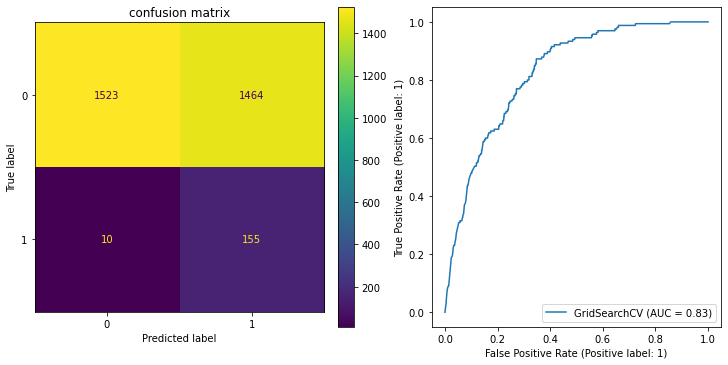

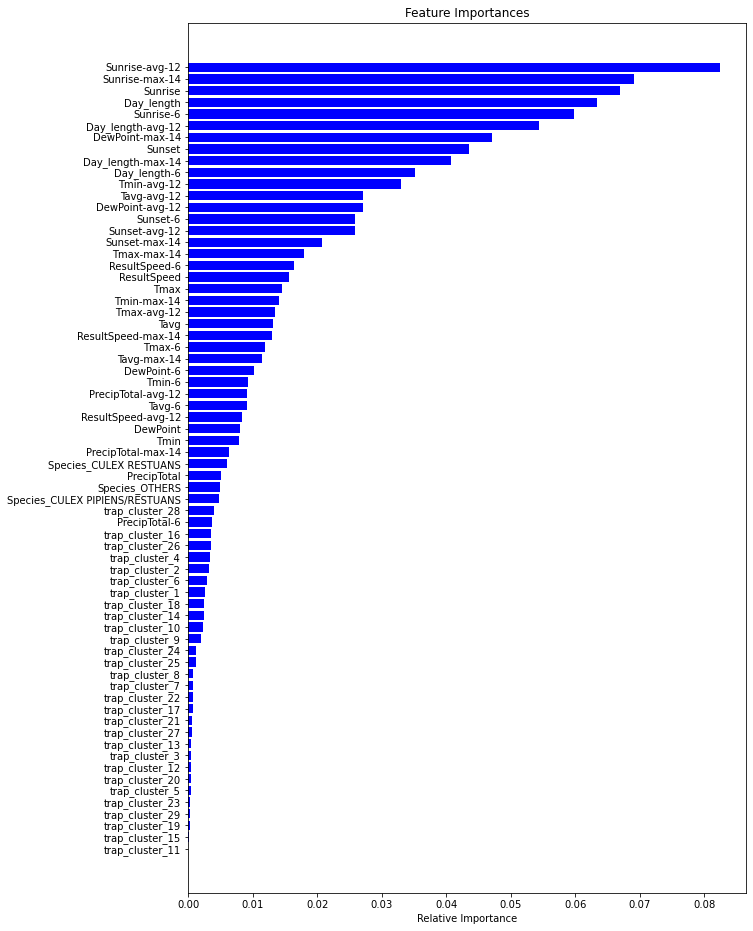

In [78]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
model = RandomForestClassifier(random_state=42)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = {'classifier__n_estimators' : [300],       #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
               }


# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_rf = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='roc_auc'
                    )

#finding the best hypermeter list for the model
run_model(gs_rf, X_train, y_train, X_test, y_test )


### Model: LGBMClassifier

best_params: 
    classifier__learning_rate  :  0.05
    classifier__max_depth  :  5
    classifier__metric  :  binary_logloss
    classifier__num_leaves  :  30

roc_auc_score on training set: 0.885
roc_auc_score on testing set: 0.836
perc_diff: 5.6 %


f1_score on training set: 0.326
f1_score on testing set: 0.288
perc_diff: 11.6 %

confusion matrix: 
                   pred No virus  pred WnvPresent
actual No virus             2504              483
actual WnvPresent             56              109

plot confusion matrix and ROC curve


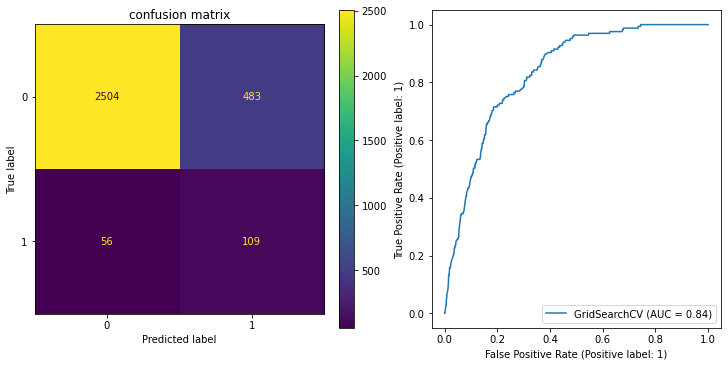

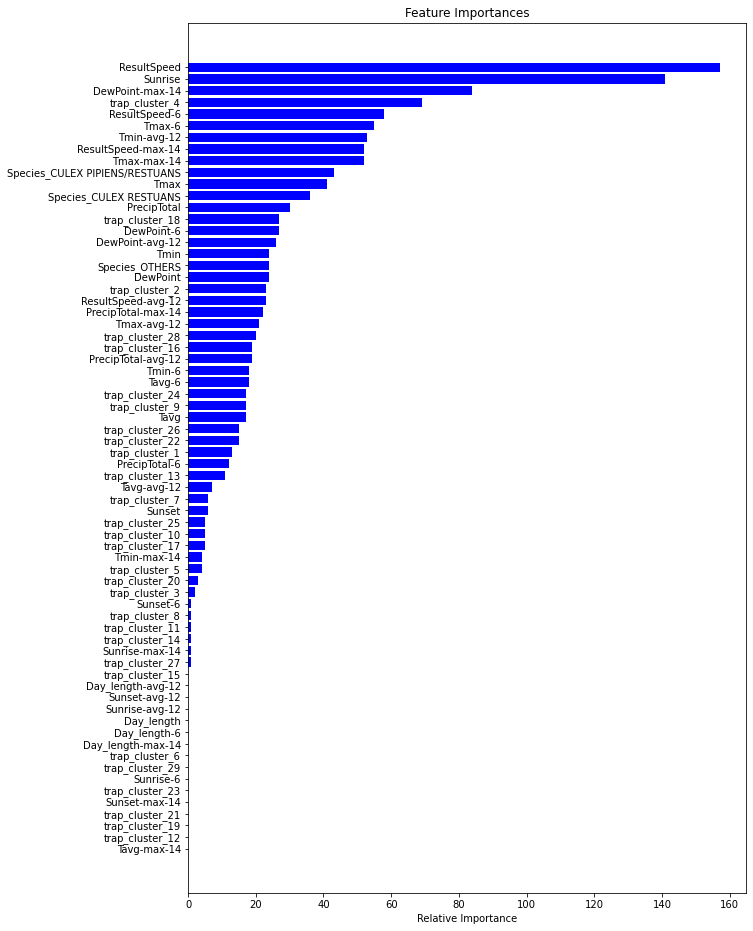

In [79]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
model = lgb.LGBMClassifier(objective='binary',random_state=42)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = { 'classifier__num_leaves' : [30,35,40],   #The number of trees in the forest.
                'classifier__learning_rate' : [.01,0.05],   #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                'classifier__metric' : ['auc', 'binary_logloss']              #The maximum depth of the tree.
                }

# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_lgb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=5, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='roc_auc'
                    )

#finding the best hypermeter list for the model
run_model(gs_lgb, X_train, y_train, X_test, y_test )


# Submission

<AxesSubplot:xlabel='WnvPresent', ylabel='Count'>

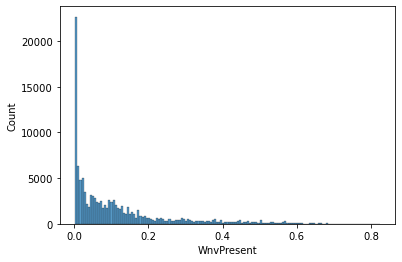

In [80]:
WnvPresent_prob_list = gs_lgb.predict_proba(X_submission)
df_test['WnvPresent'] = [list(t) for t in zip(*WnvPresent_prob_list)][1]
df_submission=df_test[['Id','WnvPresent']]
df_submission.to_csv("../assets/submission.csv",index=False)
sns.histplot(df_submission['WnvPresent'])